In [26]:
import time

def exec_time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 실행 시간: {end_time - start_time:.5f}초")
        return result
    return wrapper

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from concurrent.futures import ThreadPoolExecutor, as_completed


class ParticleFilter:
    def __init__(self, m_map, gaussian_params, num_particles, map_constraints, step_noise=0.2, step_length=1, gyro_noise=0.1, map_noise=0.2):
        """
        Initialize the particle filter.
        :param gaussian_params: Dict with Gaussian parameters {'mean_x', 'mean_y', 'std_x', 'std_y'}
        :param num_particles: Number of particles.
        :param map_constraints: Spatial constraints of the map (e.g., walls, paths).
        :param step_length: Average step length of a user.
        :param gyro_noise: Standard deviation of noise added to direction changes.
        :param map_noise: Standard deviation of noise in map matching.
        """
        m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])
        self.m_map = {(row.X, row.Y): row.mag for row in m_map_df.itertuples()}
        self.gaussian_params = gaussian_params  
        self.num_particles = num_particles
        self.map_constraints = map_constraints
        self.step_length = step_length
        self.gyro_noise = gyro_noise
        self.step_noise = step_noise
        self.map_noise = map_noise
        self.particles = self.initialize_particles()

    @exec_time_decorator
    def initialize_particles(self):
        """
        Randomly initialize particles based on map constraints.
        """
        particles = []
        for _ in range(self.num_particles):
            while True:
                # Generate x and y from Gaussian distribution
                x = np.random.normal(self.gaussian_params['mean_x'], self.gaussian_params['std_x'])
                y = np.random.normal(self.gaussian_params['mean_y'], self.gaussian_params['std_y'])
                
                # Check if the generated coordinates are within the map constraints
                if map_constraints_check(x, y, self.map_constraints):
                    break

            # Random direction for the particle
            direction = np.arctan2(x - self.gaussian_params['mean_x'], y - self.gaussian_params['mean_y'])  # Direction in radians
            
            # Initialize the particle with weight 1.0
            particles.append({'x': x, 'y': y, 'direction': direction, 'weight': 1.0})
        return particles

    @exec_time_decorator
    def move_particles(self, gyro_data):
        """
        Move particles based on step length and gyro data.
        """
        for idx, particle in enumerate(self.particles):

            # Update direction with gyro data and noise
            delta_direction = gyro_data + np.random.normal(0, self.gyro_noise)
            particle['direction'] += delta_direction

            # Move particle in updated direction
            dx = (self.step_length + self.step_noise) * np.cos(particle['direction'])
            dy = (self.step_length + self.step_noise) * np.sin(particle['direction'])
            particle['x'] += dx
            particle['y'] += dy


    # @exec_time_decorator
    @staticmethod
    def calculate_weights_worker(particle, observed_vector, m_map, map_constraints, step_length, map_noise):
        """
        Calculate particle weights using DTW similarity.
        """
        if map_constraints_check(particle['x'], particle['y'], map_constraints)==False:
            particle['weight'] = 0.000001
        else:
            # Simulate predicted vector (from M-Map) at particle's position
            predicted_vector = get_m_map_vector_(m_map, particle, step_length)  # Replace with map-based vector lookup

            observed_vector_mag_mean = sum(observed_vector) / len(observed_vector)  
            observed_vector_result = [[idx, item - observed_vector_mag_mean] for idx, item in enumerate(observed_vector)]

            predicted_vector_mag_mean = sum(predicted_vector) / len(predicted_vector)  
            predicted_vector_result = [[idx, item - predicted_vector_mag_mean] for idx, item in enumerate(predicted_vector)]

            # print(particle)
            # print("Observed Vector Result:", observed_vector_result)
            # print("Predicted Vector Result:", predicted_vector_result)

            distance, _ = fastdtw(observed_vector_result, predicted_vector_result, dist=euclidean)
            distance = round(distance*0.001, 4)
            # print(distance)
            #need distance nomalization?
            particle['weight'] = np.exp(-distance**2 / (2 * map_noise**2))
        
        return particle
    
    
    @exec_time_decorator
    def calculate_weights(self, observed_vector):
        """
        Calculate particle weights
        """
        
        # 병렬 실행 X
        # self.particles = [ self.calculate_weights_worker(
        #             particle,
        #             observed_vector,
        #             self.m_map,
        #             self.map_constraints,
        #             self.step_length,
        #             self.map_noise
        # ) for particle in self.particles]
        
        # 병렬 실행 O
        futures = [] 
        with ThreadPoolExecutor() as executor:
            for particle in self.particles:
                # 작업을 개별적으로 제출
                future = executor.submit(self.calculate_weights_worker,
                    particle,
                    observed_vector,
                    self.m_map,
                    self.map_constraints,
                    self.step_length,
                    self.map_noise
                )
                futures.append(future)

            # 완료된 작업에서 결과 수집
            self.particles = [future.result() for future in as_completed(futures)]

        
        


    @exec_time_decorator
    def resample_particles(self):
        """
        Resample particles based on their weights.
        """
        weights = np.array([p['weight'] for p in self.particles])
        weights /= np.sum(weights)  # Normalize weights


        # Resample particles based on weights
        indices = np.random.choice(len(self.particles), size=self.num_particles, p=weights)
        new_particles = [self.particles[i] for i in indices]

        # Add some noise to resampled particles to avoid over-concentration
        for particle in new_particles:
            particle['x'] += np.random.normal(0, self.map_noise)
            particle['y'] += np.random.normal(0, self.map_noise)

        self.particles = new_particles

    @exec_time_decorator
    def estimate_position(self):
        """
        Estimate user position based on particle distribution.
        """

        # for particle in self.particles:
        #     print(particle)


        weights = np.array([p['weight'] for p in self.particles])
        x_mean = np.sum([p['x'] * p['weight'] for p in self.particles]) / np.sum(weights)
        y_mean = np.sum([p['y'] * p['weight'] for p in self.particles]) / np.sum(weights)


        # x_mean = np.mean([p['x'] * p['weight'] for p in self.particles]) / np.sum(weights)
        # y_mean = np.mean([p['y'] * p['weight'] for p in self.particles]) / np.sum(weights)
        return x_mean, y_mean




    @exec_time_decorator
    def run_filter(self, observed_vector, gyro_data):
        """
        Run the particle filter over a sequence of observations.
        """
        positions = []
        self.move_particles(gyro_data)
        self.calculate_weights(observed_vector)
        self.resample_particles()
        positions.append(self.estimate_position())
        return positions


    @exec_time_decorator
    def interpolate_m_map(file_path):
        df = pd.read_csv(file_path)
        return df


# @exec_time_decorator
def map_constraints_check(x, y, map_constraints):

    """
    if the (x,y) impossible return false  
    
    
    """
    if (0 <= x < 153.5) and (0 <= y < 65.5):
        return not map_constraints[round(x),round(y)]
    else:
        return False


# @exec_time_decorator
def get_m_map_vector_(m_map, particle, step_length):
    vector = []

    dx = step_length * np.cos(particle['direction'])
    dy = step_length * np.sin(particle['direction'])

    x1 = particle['x'] - dx
    y1 = particle['y'] - dy
    
    x2 = particle['x']
    y2 = particle['y']

    

    """
    find the points from (x1, y1) to (x2, y2) 
    concat the magnitudes of points


    """
    # m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])

    # (x1, y1)에서 (x2, y2)까지 이동하는 단계 수 계산
    num_steps = 10


    # m_map의 magnitude 값을 읽어서 벡터화
    for i in range(num_steps + 1):
        # 시작점과 끝점 사이를 보간하여 (x, y) 계산
        x = np.round(x1 + (x2 - x1) * i / num_steps, 1)
        y = np.round(y1 + (y2 - y1) * i / num_steps, 1)
        
        x = float(x) if isinstance(x, np.ndarray) else x
        y = float(y) if isinstance(y, np.ndarray) else y

        # magnitude = m_map_df.loc[(m_map_df['X']==x) & (m_map_df['Y']==y), 'mag'].values
        magnitude = m_map.get((x,y), 999.9)

        # magnitude 값을 벡터에 추가
        # vector.append([i, magnitude])
        vector.append(magnitude)

    return vector



In [28]:
@exec_time_decorator
def slice_csv_by_time(file_path, start_time, end_time, time_column='seconds_elapsed'):
    df = pd.read_csv(file_path)
    vector = []
    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)].copy()

    filtered_df.reset_index(drop=True, inplace=True)


    filtered_df['Magnitude'] = np.sqrt(filtered_df['x']**2 + filtered_df['y']**2 + filtered_df['z']**2)
    
    # for index, mag in filtered_df['Magnitude'].items():
    #     vector.append([index, mag])
    vector = filtered_df['Magnitude'].to_list()

    return vector

    

In [29]:
# Example usage
if __name__ == "__main__":
    # Map constraints
    # map_constraints = {
    #     'x_min': 0,
    #     'x_max': 100,
    #     'y_min': 0,
    #     'y_max': 100
    # }
    map_constraints = np.loadtxt('data/obstacle_mask.txt', dtype=bool)
    # Simulated data
    gyro_data = np.random.normal(0, 0.1, size=1)  # Replace with real gyro data

    m_map = pd.read_csv("data/M_map_version2.csv")
    gaussian_params = {"mean_x": 24, "mean_y":24, "std_x": 1, "std_y": 1}

    start_time = 0
    time_interver = 0.5
    observed_vectors = slice_csv_by_time("data/Path3_freeOri_A31/Magnetometer.csv", start_time,start_time+time_interver)

    # Initialize particle filter
    pf = ParticleFilter(num_particles=1000, gaussian_params=gaussian_params, m_map=m_map, map_constraints=map_constraints)

    

slice_csv_by_time 실행 시간: 0.00400초
initialize_particles 실행 시간: 0.09761초


slice_csv_by_time 실행 시간: 0.00522초
move_particles 실행 시간: 0.00264초
calculate_weights 실행 시간: 2.84795초
resample_particles 실행 시간: 0.00310초
estimate_position 실행 시간: 0.00000초
run_filter 실행 시간: 2.85464초
st
slice_csv_by_time 실행 시간: 0.00799초
move_particles 실행 시간: 0.00401초
calculate_weights 실행 시간: 4.10452초
resample_particles 실행 시간: 0.00399초
estimate_position 실행 시간: 0.00100초
run_filter 실행 시간: 4.11486초
st
slice_csv_by_time 실행 시간: 0.00757초
move_particles 실행 시간: 0.00501초
calculate_weights 실행 시간: 5.13178초
resample_particles 실행 시간: 0.00255초
estimate_position 실행 시간: 0.00000초
run_filter 실행 시간: 5.14029초
st
slice_csv_by_time 실행 시간: 0.00414초
move_particles 실행 시간: 0.00252초
calculate_weights 실행 시간: 4.80639초
resample_particles 실행 시간: 0.00913초
estimate_position 실행 시간: 0.00100초
run_filter 실행 시간: 4.81904초
st
[[26.57089734 26.06769423]
 [27.69354824 28.25175846]
 [29.45522184 31.05206938]
 [31.69871204 34.55542642]]


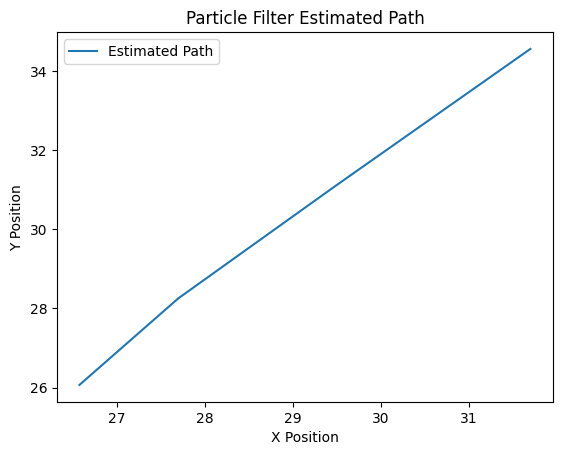

In [30]:
estimated_positions = []
for st in np.arange(0.0, 2.0, 0.5):
    observed_vectors = slice_csv_by_time("data/Path3_freeOri_A31/Magnetometer.csv", st,st + 0.5)
    estimated_positions.append(pf.run_filter(observed_vectors, 0))
    print('st')
    


# # Run the filter
# estimated_positions = pf.run_filter(observed_vectors, gyro_data)

# Plot results
estimated_positions = np.array(estimated_positions)
estimated_positions = np.squeeze(estimated_positions)  # (n, 2)로 변환

print(estimated_positions)
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], label="Estimated Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Particle Filter Estimated Path")
plt.show()
